In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [98]:
# import packages
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import cufflinks as cf  
from plotnine import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# download nltk models (only 1st time)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package averaged_perceptron_tagger to

[nltk_data]     /root/nltk_data...

[nltk_data]   Package averaged_perceptron_tagger is already up-to-

[nltk_data]       date!

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data]   Package wordnet is already up-to-date!

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...

[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [99]:
# import dataset
data = pd.read_csv('/kaggle/input/amazon-music-reviews/Musical_instruments_reviews.csv')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [100]:
data.shape

(10261, 9)

In [101]:
data.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [102]:
data.dropna(inplace = True)

In [103]:
data.isna().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [104]:
data.shape

(10227, 9)

In [105]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [106]:
data = data[['reviewText','overall','summary']]

In [107]:
data.duplicated().sum()

0

In [108]:
data.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [109]:
def cleanTextToken(text, tokenization = True):
    ''' standardize text to extract words
    '''
    # text to lowercase
    text = text.lower()
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # remove punctuation
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+') # preserve words and alphanumeric
    text = tokenizer.tokenize(text)
    # remove stopwords
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    text = [w for w in text if not w in stop] 
    # lemmatization
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(word) for word in text]
    # return clean token
    return(text)

In [110]:
# generate variable with preprocessed text
data['review_body_token'] = [cleanTextToken(text) for text in data['reviewText']]

In [111]:
data

,reviewText,overall,summary,review_body_token
0,"Not much to write about here, but it does exac...",5.0,good,"[much, write, exactly, supposed, filter, pop, ..."
1,The product does exactly as it should and is q...,5.0,Jake,"[product, exactly, quite, affordable, realized..."
2,The primary job of this device is to block the...,5.0,It Does The Job Well,"[primary, job, device, block, breath, would, o..."
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,"[nice, windscreen, protects, mxl, mic, prevent..."
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,"[pop, filter, great, look, performs, like, stu..."
...,...,...,...,...
10256,"Great, just as expected. Thank to all.",5.0,Five Stars,"[great, expected, thank]"
10257,I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...","[thinking, trying, nanoweb, string, bit, put, ..."
10258,I have tried coated strings in the past ( incl...,4.0,Good for coated.,"[tried, coated, string, past, including, elixi..."
10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,"[well, made, elixir, developed, taylor, guitar..."


In [112]:
def wordCount(txt_list):
    ''' count frequency of words in tokenized list
        and save in dataframe
    '''
    wordfreq = {'word':[],'freq':[]}
    for word in txt_list:
        if word not in wordfreq['word']:
            wordfreq['word'].append(word)                   # save word
            wordfreq['freq'].append(txt_list.count(word))   # save freq
    count = pd.DataFrame(wordfreq)
    # sort_values in df
    count.sort_values('freq', inplace=True, ascending=False)
    return count

In [113]:
def nltkPerceptronClass(column):
    ''' identify grammar class of each word in list,
        return list with classes 
    '''
    new_column =[]
    for word in column:
        new_column.append(nltk.pos_tag([word])[0][1])
    return new_column

In [114]:
# combine all words in reviews
all_tokens = []
for comment in data['review_body_token']:
    for word in comment:
        all_tokens.append(word)

In [115]:
len(all_tokens)

457631

In [116]:
# count words in reviews
all_count = wordCount(all_tokens[0:150000])

In [117]:
def nltkPerceptronClass(column):
    ''' identify grammar class of each word in list,
        return list with classes 
    '''
    new_column =[]
    for word in column:
        new_column.append(nltk.pos_tag([word])[0][1])
    return new_column

In [118]:
# identify classes for words in all_count
all_count['category'] = [nltk.pos_tag([word])[0][1] for word in all_count['word'] ]

In [119]:
# view all list of features
list(all_count.query("freq > 500 and category in ['NN', 'JJ']")['word'])

['guitar',
 'string',
 'sound',
 'great',
 'good',
 'use',
 'pick',
 'work',
 'pedal',
 'price',
 'cable',
 'much',
 'strap',
 'time',
 'little',
 'stand',
 'nice',
 'quality',
 'tone',
 'year',
 'mic',
 'play',
 'bought',
 'need']

In [120]:
features = list(all_count.query("freq > 500 and category in ['NN', 'JJ']")['word'])

In [121]:
def wordsInRow(words, token_row):
    ''' indentify if words is in list of tokens,
        return list with words intersected 
    '''
    new_row = []
    for word in words:
        if word in token_row:
            new_row.append(word)
    return new_row

In [122]:
# capture aspects in review
data['review_aspects'] = data['review_body_token'].apply(lambda row: wordsInRow(features, row)) 

In [123]:
# capture adjectives in review
adjectives = list(all_count['word'][all_count['category'] == 'JJ'])
data['review_adjectives'] = data['review_body_token'].apply(lambda row: wordsInRow(adjectives, row)) 

In [124]:
# review user binary classification
data['review_classification'] = [1 if x >= 4 else -1 for x in data['overall']]

In [125]:
data

,reviewText,overall,summary,review_body_token,review_aspects,review_adjectives,review_classification
0,"Not much to write about here, but it does exac...",5.0,good,"[much, write, exactly, supposed, filter, pop, ...","[sound, work, price, much]",[much],1
1,The product does exactly as it should and is q...,5.0,Jake,"[product, exactly, quite, affordable, realized...",[work],"[small, expensive, old, next, affordable]",1
2,The primary job of this device is to block the...,5.0,It Does The Job Well,"[primary, job, device, block, breath, would, o...","[sound, little, stand, need]","[little, high, noticeable]",1
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,"[nice, windscreen, protects, mxl, mic, prevent...","[nice, mic]","[nice, able]",1
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,"[pop, filter, great, look, performs, like, stu...",[great],"[great, vocal]",1
...,...,...,...,...,...,...,...
10256,"Great, just as expected. Thank to all.",5.0,Five Stars,"[great, expected, thank]",[great],[great],1
10257,I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...","[thinking, trying, nanoweb, string, bit, put, ...","[guitar, string, sound, great, good, pick, pri...","[great, good, much, last, new, high, different...",1
10258,I have tried coated strings in the past ( incl...,4.0,Good for coated.,"[tried, coated, string, past, including, elixi...","[guitar, string, sound, much, need]","[much, regular, certain, reasonable]",1
10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,"[well, made, elixir, developed, taylor, guitar...","[guitar, string, sound, great, good, time, lit...","[great, good, little, new, high, different, lo...",1


In [126]:
# reset index
data.reset_index(inplace=True)

In [127]:
def ruledSentimentTextAgg(token_list, category, rule='near'):
    ''' aggregate text in token list based on rules:
        all - agg all tokens in list
        next - agg tokens next to the word
        near - agg tokens 3 words far from category word
     '''
    text = ''
    for i in range(len(token_list)):
        if category in token_list[i]:
            row = token_list[i]
            cat_index = row.index(category)
            if rule == 'all':
                for word in row:
                    text = text + word + ' '  
            if rule == 'next':
                if cat_index > 0:
                    text += row[cat_index-1] + ' '
                if cat_index < (len(row)-1):
                    text += row[cat_index+1] + ' '
            if rule == 'near':
                count_id = 0
                while count_id < 3:
                    try:
                        word = row[cat_index+count_id]
                        if nltk.pos_tag([word])[0][1] == 'JJ':
                            text += word + ' '
                    except:
                        pass
                    count_id += 1
                count_id = 0    
                while count_id > -3:
                    try:
                        word = row[cat_index+count_id]
                        if nltk.pos_tag([word])[0][1] == 'JJ':
                            text += word + ' '
                    except:
                        pass
                    count_id -= 1
    return text

In [128]:
def wordcloudVisualization(text, max_words):
    ''' generate wordcloud plot based on text entry
    '''
    %matplotlib inline
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(max_font_size=50, max_words=max_words, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [129]:
def aspectSentimentWordcloud(data, classification, aspect, max_words, rule='near'):
    ''' execute the sentiment wordcloud analysis, 
        filter classification positive (1) or negative (-1), 
        combine ruledSentimentTextAgg and wordcloudVisualization
    '''
    data_posi = data[data['review_classification'] == classification].reset_index()
    text = ruledSentimentTextAgg(data_posi['review_body_token'], aspect, rule)
    wordcloudVisualization(text, max_words)

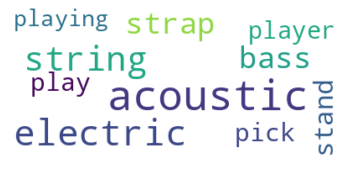

In [130]:
# POSITIVE TERMS IN NEXT WORDS
aspectSentimentWordcloud(data, classification=1, aspect='guitar', max_words=10, rule='next')

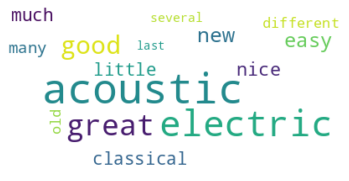

In [131]:
# POSITIVE SENTIMENTS FOR 'GUITAR' IN NEAR WORDS
aspectSentimentWordcloud(data, classification=1, aspect='guitar', max_words=15, rule='near')

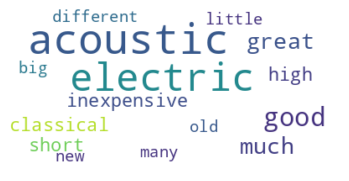

In [132]:
# NEGATIVE SENTIMENTS FOR 'GUITAR' IN NEAR WORDS
aspectSentimentWordcloud(data, classification=-1, aspect='guitar', max_words=15, rule='near')

In [133]:
data

,index,reviewText,overall,summary,review_body_token,review_aspects,review_adjectives,review_classification
0,0,"Not much to write about here, but it does exac...",5.0,good,"[much, write, exactly, supposed, filter, pop, ...","[sound, work, price, much]",[much],1
1,1,The product does exactly as it should and is q...,5.0,Jake,"[product, exactly, quite, affordable, realized...",[work],"[small, expensive, old, next, affordable]",1
2,2,The primary job of this device is to block the...,5.0,It Does The Job Well,"[primary, job, device, block, breath, would, o...","[sound, little, stand, need]","[little, high, noticeable]",1
3,3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,"[nice, windscreen, protects, mxl, mic, prevent...","[nice, mic]","[nice, able]",1
4,4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,"[pop, filter, great, look, performs, like, stu...",[great],"[great, vocal]",1
...,...,...,...,...,...,...,...,...
10222,10256,"Great, just as expected. Thank to all.",5.0,Five Stars,"[great, expected, thank]",[great],[great],1
10223,10257,I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...","[thinking, trying, nanoweb, string, bit, put, ...","[guitar, string, sound, great, good, pick, pri...","[great, good, much, last, new, high, different...",1
10224,10258,I have tried coated strings in the past ( incl...,4.0,Good for coated.,"[tried, coated, string, past, including, elixi...","[guitar, string, sound, much, need]","[much, regular, certain, reasonable]",1
10225,10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,"[well, made, elixir, developed, taylor, guitar...","[guitar, string, sound, great, good, time, lit...","[great, good, little, new, high, different, lo...",1


In [134]:
x_train,x_test,y_train,y_test = train_test_split(data.review_body_token,data.review_classification,test_size = 0.2 , random_state = 0)

In [135]:
good = x_train[y_train[y_train == 1].index]
bad = x_train[y_train[y_train == -1].index]
x_train.shape,good.shape,bad.shape

((8181,), (7185,), (996,))

In [136]:
# Convert lists to strings
x_train_str = [' '.join(text) for text in x_train]
x_test_str = [' '.join(text) for text in x_test]

cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

# transformed train reviews
cv_train_reviews = cv.fit_transform(x_train_str)
# transformed test reviews
cv_test_reviews = cv.transform(x_test_str)

print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)

BOW_cv_train: (8181, 509645)

BOW_cv_test: (2046, 509645)


In [137]:

tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))
# transformed train reviews
tv_train_reviews = tv.fit_transform([' '.join(doc) for doc in x_train])
# transformed test reviews
tv_test_reviews = tv.transform([' '.join(doc) for doc in x_test])

print('tfidf_tv_train:', tv_train_reviews.shape)
print('tfidf_tv_test:', tv_test_reviews.shape)

tfidf_tv_train: (8181, 509645)

tfidf_tv_test: (2046, 509645)


In [138]:
# join words in each review with a whitespace separator
x_train_str = [' '.join(review) for review in x_train]
x_test_str = [' '.join(review) for review in x_test]

# create pipeline for bag of words with logistic regression
lr_bow_pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=0,max_df=1,ngram_range=(1,3))),
    ('lr', LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0))
])

# create pipeline for tfidf features with logistic regression
lr_tfidf_pipeline = Pipeline([
    ('tv', TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))),
    ('lr', LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0))
])

# create pipeline for bag of words with naive bayes
nb_bow_pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=0,max_df=1,ngram_range=(1,3))),
    ('nb', MultinomialNB())
])

# fit and predict with bag of words logistic regression pipeline
lr_bow_pipeline.fit(x_train_str, y_train)
lr_bow_predictions = lr_bow_pipeline.predict(x_test_str)

# fit and predict with tfidf logistic regression pipeline
lr_tfidf_pipeline.fit(x_train_str, y_train)
lr_tfidf_predictions = lr_tfidf_pipeline.predict(x_test_str)

# fit and predict with bag of words naive bayes pipeline
nb_bow_pipeline.fit(x_train_str, y_train)
nb_bow_predictions = nb_bow_pipeline.predict(x_test_str)

# create pipeline for random forest with bag of words
rf_bow_pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=0,max_df=1,ngram_range=(1,3))),
    ('rf', RandomForestClassifier(n_estimators=100))
])

# fit and predict with bag of words random forest pipeline
rf_bow_pipeline.fit(x_train_str, y_train)
rf_bow_predictions = rf_bow_pipeline.predict(x_test_str)


In [139]:
#Accuracy score for bag of words with logistic regression pipeline
lr_bow_score = lr_bow_pipeline.score(x_test_str, y_test)
print("lr_bow_score :", lr_bow_score)

#Accuracy score for tfidf features with logistic regression pipeline
lr_tfidf_score = lr_pipeline.score(x_test_str, y_test)
print("lr_tfidf_score :", lr_tfidf_score)

#Accuracy score for bag of words with naive bayes pipeline
nb_bow_score = nb_pipeline.score(x_test_str, y_test)
print("nb_bow_score :", nb_bow_score)

#Accuracy score for tfidf features with naive bayes pipeline
nb_tfidf_score = nb_pipeline.score(x_test_str, y_test)
print("nb_tfidf_score :", nb_tfidf_score)

#Accuracy score for bag of words with random forest pipeline
rf_bow_score = rf_pipeline.score(x_test_str, y_test)
print("rf_bow_score :", rf_bow_score)

#Accuracy score for tfidf features with random forest pipeline
rf_tfidf_score = rf_pipeline.score(x_test_str, y_test)
print("rf_tfidf_score :", rf_tfidf_score)

#Accuracy score for naive bayes pipeline
nb_score = nb_pipeline.score(x_test_str, y_test)
print("nb_score :", nb_score)

#Accuracy score for random forest pipeline
rf_score = rf_pipeline.score(x_test_str, y_test)
print("rf_score :", rf_score)

lr_bow_score : 0.8831867057673509

lr_tfidf_score : 0.8831867057673509

nb_bow_score : 0.8455522971652004

nb_tfidf_score : 0.8455522971652004

rf_bow_score : 0.8831867057673509

rf_tfidf_score : 0.8831867057673509

nb_score : 0.8455522971652004

rf_score : 0.8831867057673509


In [140]:
# Classification report for bag of words with logistic regression pipeline
lr_bow_predict = lr_bow_pipeline.predict(x_test_str)
lr_bow_report = classification_report(y_test, lr_bow_predict, target_names=['0', '1'])
lr_bow_accuracy = accuracy_score(y_test, lr_bow_predict)
print("Logistic Regression with Bag of Words\nAccuracy:", lr_bow_accuracy, "\n", lr_bow_report)

# Classification report for tfidf features with logistic regression pipeline
lr_tfidf_predict = lr_pipeline.predict(x_test_str)
lr_tfidf_report = classification_report(y_test, lr_tfidf_predict, target_names=['0', '1'])
lr_tfidf_accuracy = accuracy_score(y_test, lr_tfidf_predict)
print("Logistic Regression with TF-IDF\nAccuracy:", lr_tfidf_accuracy, "\n", lr_tfidf_report)

# Classification report for bag of words with naive bayes pipeline
nb_bow_predict = nb_pipeline.predict(x_test_str)
nb_bow_report = classification_report(y_test, nb_bow_predict, target_names=['0', '1'])
nb_bow_accuracy = accuracy_score(y_test, nb_bow_predict)
print("Naive Bayes with Bag of Words\nAccuracy:", nb_bow_accuracy, "\n", nb_bow_report)

# Classification report for tfidf features with naive bayes pipeline
nb_tfidf_predict = nb_pipeline.predict(x_test_str)
nb_tfidf_report = classification_report(y_test, nb_tfidf_predict, target_names=['0', '1'])
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predict)
print("Naive Bayes with TF-IDF\nAccuracy:", nb_tfidf_accuracy, "\n", nb_tfidf_report)

# Classification report for bag of words with random forest pipeline
rf_bow_predict = rf_pipeline.predict(x_test_str)
rf_bow_report = classification_report(y_test, rf_bow_predict, target_names=['0', '1'])
rf_bow_accuracy = accuracy_score(y_test, rf_bow_predict)
print("Random Forest with Bag of Words\nAccuracy:", rf_bow_accuracy, "\n", rf_bow_report)

# Classification report for tfidf features with random forest pipeline
rf_tfidf_predict = rf_pipeline.predict(x_test_str)
rf_tfidf_report = classification_report(y_test, rf_tfidf_predict, target_names=['0', '1'])
rf_tfidf_accuracy = accuracy_score(y_test, rf_tfidf_predict)
print("Random Forest with TF-IDF\nAccuracy:", rf_tfidf_accuracy, "\n", rf_tfidf_report)


Logistic Regression with Bag of Words

Accuracy: 0.8831867057673509 

               precision    recall  f1-score   support



           0       0.67      0.01      0.02       240

           1       0.88      1.00      0.94      1806



    accuracy                           0.88      2046

   macro avg       0.78      0.50      0.48      2046

weighted avg       0.86      0.88      0.83      2046



Logistic Regression with TF-IDF

Accuracy: 0.8831867057673509 

               precision    recall  f1-score   support



           0       0.67      0.01      0.02       240

           1       0.88      1.00      0.94      1806



    accuracy                           0.88      2046

   macro avg       0.78      0.50      0.48      2046

weighted avg       0.86      0.88      0.83      2046



Naive Bayes with Bag of Words

Accuracy: 0.8455522971652004 

               precision    recall  f1-score   support



           0       0.24      0.15      0.18       240

           1     

Based on the accuracy scores, it looks like the best overall model is the logistic regression model with either the bag of words or tf-idf features, since they both have the highest accuracy score of 0.8832.